In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from agents.professeur import agent_professeur
from agents.exercice import agent_exercice
from agents.correcteur import agent_correcteur

# Définition du schéma de l'état
class ChatState(TypedDict):
    question: str

# Fonction de routage (Tuteur)
def route_request(state: ChatState):
    question = state["question"].lower()
    if "exercice" in question:
        return {"next_node": "exercice"}       # retourne un dict
    elif "corrige" in question or "réponse" in question:
        return {"next_node": "correcteur"}     # retourne un dict
    else:
        return {"next_node": "professeur"}     # retourne un dict

# Création du graphe avec le schéma d'état
graph = StateGraph(ChatState)

# Ajouter les agents comme nodes
graph.add_node("professeur", agent_professeur)
graph.add_node("exercice", agent_exercice)
graph.add_node("correcteur", agent_correcteur)

# Ajouter le routeur comme node
graph.add_node("router", route_request)

# Définir le point d'entrée sur le routeur
graph.set_entry_point("router")

# Définir les sorties vers END pour chaque agent
graph.add_edge("professeur", END)
graph.add_edge("exercice", END)
graph.add_edge("correcteur", END)

# Compiler le graphe
compiled_graph = graph.compile()


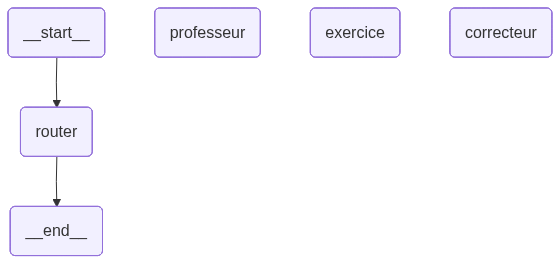

In [3]:
compiled_graph

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [ ]:
llm = ChatOpenAI(model="gpt-4o")


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
from langchain.schema import SystemMessage

sys_msg = SystemMessage(
    content=(
        """Tu es un assistant éducatif dont le rôle est d'aider les élèves à réviser et à apprendre.
        Tu dois d'abord demander la classe de l'élève si tu ne la connais pas.
        Une fois que tu connais la classe, tu la gardes en mémoire pour toutes les prochaines interactions."""
    )
)



# Node

def assistant(state: MessagesState):
   return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

In [ ]:
# NODE router
from langchain.schema import SystemMessage

def exercice(state: MessagesState):
    msg = SystemMessage(
        content=(
            """Tu es un routeur de messages.

            Analyse la question de l'élève et retourne uniquement UN mot parmi :
              - "Exercice" → si l'élève demande un exercice de mathématiques.
              - "Apprendre" → si l'élève veut apprendre ou comprendre une notion.
              - "Corriger" → si l'élève demande la correction d'un exercice.
              - "Invalide" → si la demande ne correspond pas aux cas ci-dessus.

            Réponds uniquement par un de ces quatre tags, sans phrase supplémentaire.
            """
        )
    )

    response = llm.invoke([msg] + state["messages"])
    return {"tag": response.content}
